In [70]:
%run Function_Master.ipynb
%run Parameterization.ipynb

## Generating Individual Sources and Sinks

In [71]:
def svs(sol, param):
    
    """Sources and sinks of each constituant in the coupled NPZV model.
    
    sol: solve_ivp solution object
    param: all parameters needed for calulation
    """
    
    #Parameter definitions (floats)
    V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, \
    μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω = param
    
    L = len(sol.t)
    
    #Defineing state solutions (arrays)
    N_n = sol.y[0] #New nutrients (Nitrate)
    N_r = sol.y[1] #Recycled Nutrients (Ammonium)
    P_U = sol.y[2] #Susceptible Hosts
    P_I = sol.y[3] #Infected Hosts
    Z   = sol.y[4] #Zooplankton
    V_I = sol.y[5] #Internal viruses from host NT recycling and de novo NT synthesis
    V_E = sol.y[6] #Free (extracellular) viruses 
    
    alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
    beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3
    
    P = P_U + P_I                                #array
    N = N_n + N_r                                #array
    nutr_lim = N / (K_N + N)                     #array
    light_lim = np.log((K_I + I_0 / K_I)) / K_h  #float
    psi = V_max * nutr_lim * light_lim           #array
    
    ν_i = np.zeros(L)
    scales = [[], [], []] #scales only apply Pu, Pi, Z, Vi
    
    #Defing arrays that require specific logic at each step
    for i in range(L):
        
        if N[i] == 0: N[i] = 1 #avoid divison by 0 when evaluating nutrient ratios
                               #shouldn't affect nutrient limitation terms

        if V_I[i] != 0: ν_i[i] = V_I[i] / ((beta / alpha) * P_I[i] + V_I[i])

        #Defining the scaling factors that continuously reduce the affect of growth
        #as state variables reach ecologically unrealistic densities (e.g. 1e-20)
        
        thresh = [1e-12, 1e-12, 1e-12, 1e-12]  #threshold for when growth damping begins
    
        for j, state in enumerate([P_U[i], P_I[i], Z[i]]):
            
            scale = 1
            if state < thresh[j]: scale = state / thresh[j] 
            scales[j].append(scale)

    P_U_scale, P_I_scale, Z_scale = np.array(scales) #arrays
    V_I_scale = P_I_scale
    
    #Correction term for P_I with low V_I
    recovered_correction = []
    
    adsorp_sub_VE = V_E - np.full(L, 1e-12) 
                      
    for i in range(L):
        V_P_thresh = 6e-7 #corresponds to a 10th of a virus per host ratio
        recovered_correction.append(max(0, P_I[i] - (V_I[i] / V_P_thresh))) #/time_scale = 1 day

        #creation of adsorption cut off
        if adsorp_sub_VE[i] < 0:
            adsorp_sub_VE[i] = 0

    #Infected Phytoplankton
    P_I_svs = {}
    
    P_I_svs["Growth"]    = P_I_scale * (1 - P_U_scale * μ_u) * P_I * psi
    P_I_svs["Adsorp"]    = (1 - ν_x) * φ * μ_s * P_U * adsorp_sub_VE
    P_I_svs["Grazing"]   = P_I * Z_scale * g * Z / K_P
    P_I_svs["Mortality"] = P_I * λ_P
    P_I_svs["NT_recy"]   = V_I_scale * P_I * ν_i * μ_V
    P_I_svs["Lysis"]     = P_I * ν_i * δ
    
    P_I_svs["Sources"] = P_I_svs["Growth"] + P_I_svs["Adsorp"]
    P_I_svs["Sinks"]   = P_I_svs["Grazing"] + P_I_svs["Mortality"] \
                         + P_I_svs["NT_recy"] + P_I_svs["Lysis"]
    
    P_I_svs["dP_Idt"]  = P_I_svs["Sources"] - P_I_svs["Sinks"]
    
    #Zooplankton
    Z_svs = {}
    
    Z_svs["Assim"]     = Z * Z_scale * γ_Z * g * (P + V_I) / K_P
    Z_svs["Mortality"] = Z * (λ_Z + λ_Z_hat * Z)
    
    Z_svs["Sources"] = Z_svs["Assim"]
    Z_svs["Sinks"]   = Z_svs["Mortality"]
    Z_svs["dP_Idt"]  = Z_svs["Sources"] - Z_svs["Sinks"]
    
    #Intracellular Viruses 
    V_I_svs = {}
    
    V_I_svs["NT_Recyc"]   = V_I_scale * (beta / alpha) * ν_i * μ_V * P_I
    V_I_svs["Denovo_Syn"] = V_I_scale * (beta / alpha) * ν_i * nutr_lim * μ_V_prime * P_I
    V_I_svs["Adsorp"]     = (beta / alpha) * ν_x * φ * μ_s * P_U * adsorp_sub_VE
    V_I_svs["Grazing"]    = V_I * Z_scale * g * Z / K_P
    V_I_svs["Lysis"]      = V_I * ν_i * δ
    V_I_svs["Host Mort"]  = V_I * λ_P
    
    V_I_svs["Sources"] = V_I_svs["NT_Recyc"] + V_I_svs["Denovo_Syn"] + V_I_svs["Adsorp"]
    V_I_svs["Sinks"]   = V_I_svs["Grazing"] + V_I_svs["Lysis"] + V_I_svs["Host Mort"]
    V_I_svs["dV_Idt"]  = V_I_svs["Sources"] - V_I_svs["Sinks"]

    return P_I_svs, Z_svs, V_I_svs


### Pulling Example Solution

#### Solution Set

In [4]:
%store -r sols

#multiple runs
num = 1
N_t, test_sol = sols[num][0], sols[num][1]
print(sum(N_t), N_t)

P_I_svs, Z_svs, V_I_svs = svs(test_sol, param)

0.003000212095238095 [0.0, 0.001, 0.001, 1e-07, 0.001, 1e-07, 1.2095238095238098e-08]


#### Single Solution

In [72]:
%store -r sol
#one run
test_sol = sol
P_I_svs, Z_svs, V_I_svs = svs(test_sol, param)

## Plotting Functions

### P_I Visualization of SvS

In [73]:
def P_I_svs_visual(sol, P_I_svs): 

    time_span = sol.t
    P_I = sol.y[3]

    states = [sol.y[i] for i in range(7)]

    labels = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']
    colors = ["darkviolet", "blue", "mediumaquamarine", "yellowgreen", "darkgreen", "red", "darkred"]

    fig = plt.figure(figsize = (10, 6))
    # ax = fig.subplot_mosaic("""AB;CD;EE""")
    ax = fig.subplot_mosaic("""BB;EE""")
    
    #Visualizing Dynamics
    for i in range(7): 
        # ax["A"].plot(time_span, states[i], color=colors[i], label=labels[i])
        ax["B"].plot(time_span, states[i], color=colors[i], label=labels[i])

    # ax["A"].set_title('System Dynamics', fontsize=10)
    # ax["A"].set_ylabel(r'Nutrients ($mmol/m^3$)')

    #one run
    title = (f'Total N: {sum([test_sol.y[i][0] for i in range(6)]):.8}, '
         f'for Nr_0 = {test_sol.y[1][0]:.4}, '
         f'Pu_0 = {test_sol.y[2][0]:.4}, '
         f'Pi_0 = {test_sol.y[3][0]:.4}, '
         f'Z_0 = {test_sol.y[4][0]:.4}, '
         f'Vi_0 = {test_sol.y[5][0]:.4}, '
         f'Ve_0 = {test_sol.y[6][0]:.4}')

    ax["B"].set_title(title, fontsize=10)
    ax["B"].set_yscale('log')
    ax["B"].set_ylim(1e-20, 2e-1)

    ### Visualizing P_I sources and sinks
#     for plot in ["C", "D"]:
#         for key in ['Growth','Adsorp']:
#             ax[plot].plot(time_span, P_I_svs[key], label=key, alpha=.7)
            
#         for key in ['Grazing','Mortality','NT_recy','Lysis']:
#             ax[plot].plot(time_span, P_I_svs[key], '--', label=key, alpha=.7)

#         ax[plot].plot(time_span, P_I_svs["Sources"], color='black', label="Sources")
#         ax[plot].plot(time_span, P_I_svs["Sinks"], '--', color='black', label="Sinks")

#     ax["C"].set_title('P_I Sources and Sinks', fontsize=10)
#     ax["C"].set_ylabel('Nutrients per Day \n ($mmol \cdot m^{-3} \cdot d^{-1}$)')
#     #ax["C"].set_ylim(-1e-4, .002)

#     ax["D"].set_title('P_I Sources and Sinks - Semilog Y Scale', fontsize=10)
#     ax["D"].set_yscale('log')
#     ax["D"].set_ylim(1e-20, 1e-2)

    for key in ['Growth','Adsorp']:
        ax["E"].plot(time_span, P_I_svs[key] / P_I, label=key, alpha=.7)
    for key in ['Grazing','Mortality','NT_recy','Lysis']:
        ax["E"].plot(time_span, P_I_svs[key] / P_I, '--', label=key, alpha=.7)

    ax["E"].plot(time_span, P_I_svs["Sources"] / P_I, color='black', label="Sources")
    ax["E"].plot(time_span, P_I_svs["Sinks"] / P_I, '--', color='black', label="Sinks")
    ax["E"].set_title('Normalized P_I Sources and Sinks', fontsize=10)
    ax["E"].set_ylabel('dt ($day^{-1}$)', fontsize=10)
    ax["E"].set_ylim(-0.1, 1.1)
    
    for plot in ax:
        ax[plot].set_xlabel('Time (days)')
        ax[plot].set_xlim(-5, 200)

        ax[plot].grid(which='both', alpha=.3)
        ax[plot].minorticks_on()

    ax["B"].legend(loc=(1.01, 0), framealpha=1)
    # ax["D"].legend(loc=(1.01, 0), framealpha=1)
    ax["E"].legend(loc=(1.01, 0), framealpha=1)
    plt.tight_layout()
    plt.show()
    
    return

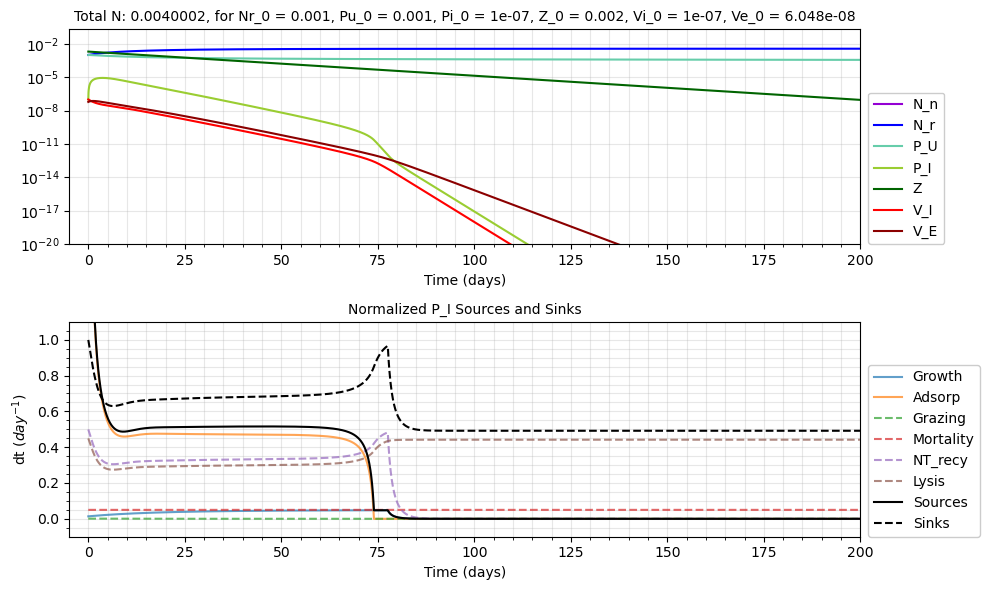

In [74]:
P_I_svs_visual(test_sol, P_I_svs)

### V_I Visualization of SvS

In [10]:
def V_I_svs_visual(sol, V_I_svs): 

    time_span = sol.t
    V_I = sol.y[5]

    states = [sol.y[i] for i in range(7)]

    labels = ['N_n', 'N_r', 'P_U', 'P_I', 'Z', 'V_I', 'V_E']
    colors = ["darkviolet", "blue", "mediumaquamarine", "yellowgreen", "darkgreen", "red", "darkred"]

    fig = plt.figure(figsize = (14, 10))
    ax = fig.subplot_mosaic("""AB;CD;EE""")

    #Visualizing Dynamics
    for i in range(7): 
        ax["A"].plot(time_span, states[i], color=colors[i], label=labels[i])
        ax["B"].plot(time_span, states[i], color=colors[i], label=labels[i])

    ax["A"].set_title('System Dynamics', fontsize=10)
    ax["A"].set_ylabel(r'Nutrients ($mmol/m^3$)')

    ax["B"].set_title('System Dynamics - Semilog Y Scale', fontsize=10)
    ax["B"].set_yscale('log')
    ax["B"].set_ylim(1e-30, 10)

    ### Visualizing V_I sources and sinks
    for plot in ["C", "D"]:
        for key in ['NT_Recyc', 'Denovo_Syn','Adsorp']:
            ax[plot].plot(time_span, V_I_svs[key], label=key, alpha=.3)
        for key in ['Grazing','Host Mort','Lysis']:
            ax[plot].plot(time_span, V_I_svs[key], '--', label=key, alpha=.3)

        ax[plot].plot(time_span, V_I_svs["Sources"], color='black', label="Sources")
        ax[plot].plot(time_span, V_I_svs["Sinks"], '--', color='black', label="Sinks")

    ax["C"].set_title('V_I Sources and Sinks', fontsize=10)
    ax["C"].set_ylabel('Nutrients per Day \n ($mmol \cdot m^{-3} \cdot d^{-1}$)')
    ax["C"].legend()

    ax["D"].set_title('V_I Sources and Sinks - Semilog Y Scale', fontsize=10)
    ax["D"].set_yscale('log')
    ax["D"].set_ylim(1e-30, 1e-3)

    for key in ['NT_Recyc', 'Denovo_Syn','Adsorp']:
        ax["E"].plot(time_span, V_I_svs[key] / V_I, label=key, alpha=.5)
    for key in ['Grazing','Host Mort','Lysis']:
        ax["E"].plot(time_span, V_I_svs[key] / V_I, '--', label=key, alpha=.5)

    ax["E"].plot(time_span, V_I_svs["Sources"] / V_I, color='black', label="Sources")
    ax["E"].plot(time_span, V_I_svs["Sinks"] / V_I, '--', color='black', label="Sinks")
    ax["E"].set_title('Normalized V_I Sources and Sinks', fontsize=10)
    ax["E"].set_ylabel('dt ($day^{-1}$)', fontsize=10)
    ax["E"].set_ylim(-.1, .8)

    for plot in ax:
        ax[plot].set_xlabel('Time (days)')
        ax[plot].set_xlim(-5, 500)

        ax[plot].grid(which='both', alpha=.3)
        ax[plot].minorticks_on()

    ax["B"].legend(loc=(1.01, 0), framealpha=1)
    ax["D"].legend(loc=(1.01, 0), framealpha=1)
    ax["E"].legend(loc=(1.01, 0), framealpha=1)
    plt.tight_layout()
    plt.show()
    
    return

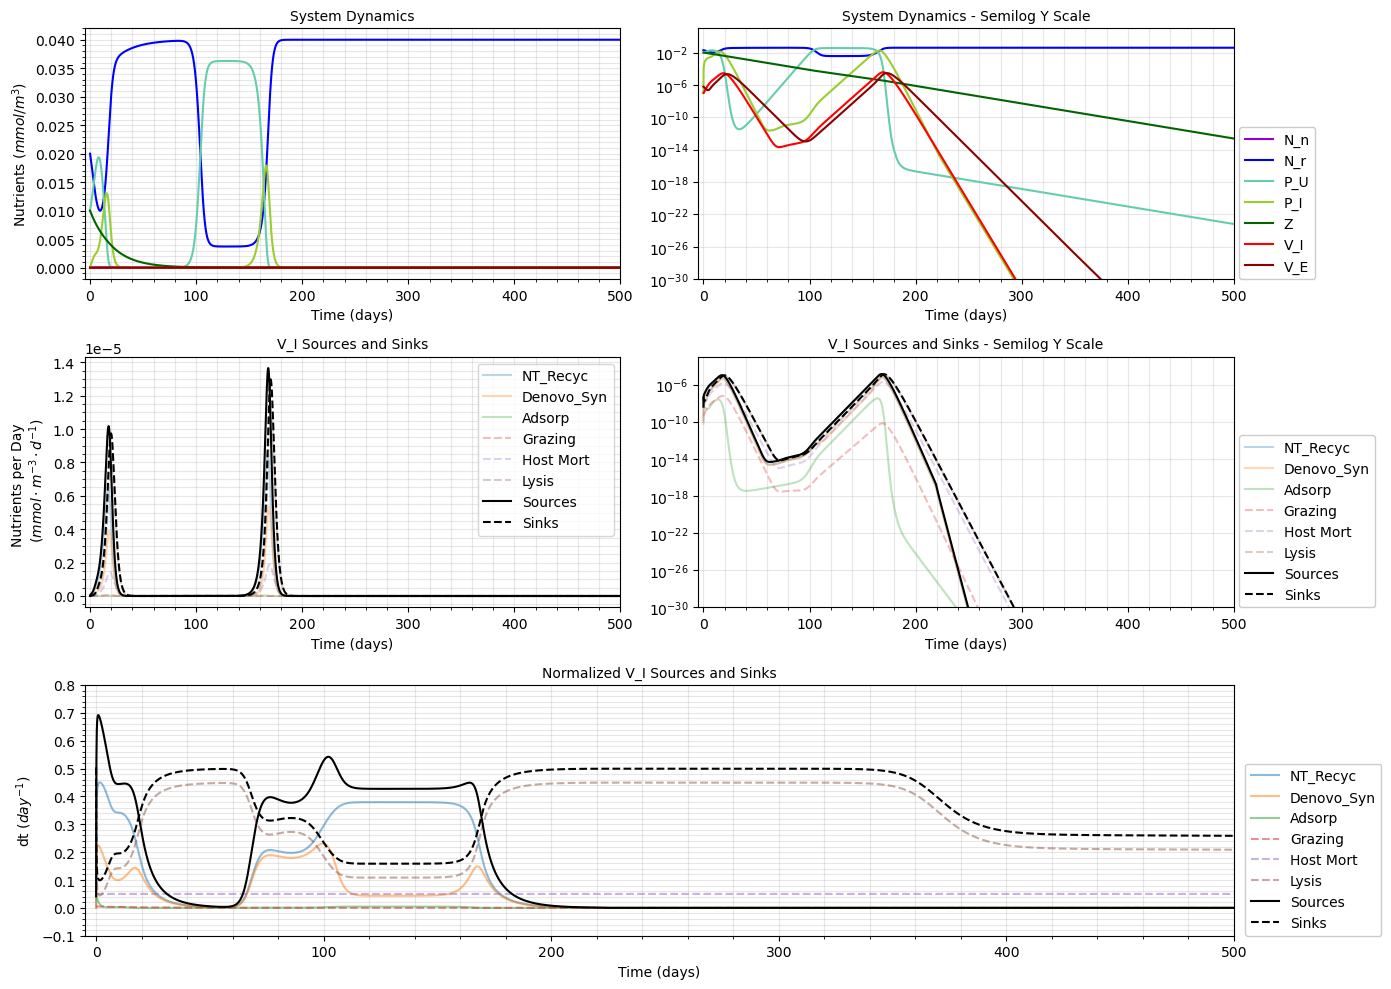

In [11]:
V_I_svs_visual(test_sol, V_I_svs)

## Slope Test Examples

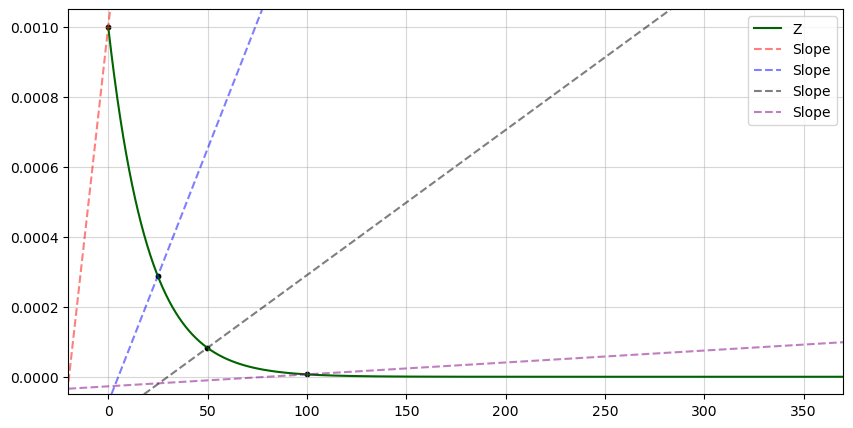

In [9]:
#Z slope tests example
t = test_sol.t
Z = test_sol.y[4]

plt.figure(figsize=(10, 5))
plt.plot(t, Z, color='darkgreen', label='Z')

index = [0, 250, 500, 1000]
colors = ['red', 'blue', 'black', 'purple']

for i in range(len(index)):
    plt.scatter(t[index[i]], Z[index[i]], color='black', s=10)
    plt.axline((t[index[i]], Z[index[i]]), 
               slope=sum(Z_svs.values())[index[i]], 
               color=colors[i], linestyle='--', label='Slope', alpha=.5)

plt.xlim(-20, 370)
plt.legend()
plt.grid(alpha=.5)
plt.show()

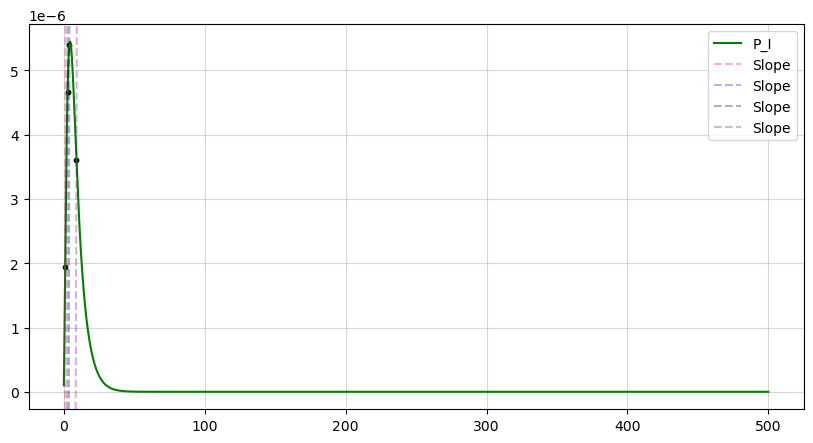

In [10]:
#P_I Slope tests example
t = test_sol.t
P_I = test_sol.y[3]

plt.figure(figsize=(10, 5))
plt.plot(t, P_I, color='green', label='P_I')

index = [10, 27, 40, 90]
colors = ['red', 'blue', 'black', 'purple']

slopes = sum(P_I_svs.values())

for i in range(len(index)):
    plt.scatter(t[index[i]], P_I[index[i]], color='black', s=10)
    plt.axline((t[index[i]], P_I[index[i]]), slope=slopes[index[i]], 
               linestyle='--', color=colors[i], label='Slope', alpha=.3)

# plt.xlim(-5, 25)
# plt.ylim(-5e-5, 1e-3)

plt.legend()
plt.grid(alpha=.5)
plt.show()